<a href="https://colab.research.google.com/github/Ashok401/AIML_BootCamp/blob/main/Capstone/Capstone_iPhone_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sentiment Analysis
- Data Source: iPhone reviews from Amazon India, downloaded from Kaggle.
- Data cleaning, preprocessing and exploratory data analysis.
- Deep Dive into Major Issues Reported in Phone Reviews: Analyzing and categorizing significant issues mentioned in the reviews.
- Observations:
  - 128GB, a blue color, sold the highest units among all iPhone models.
  - The majority of customers are satisfied with the camera quality but disappointed with the battery drain.



In [ ]:
# Data set : https://www.kaggle.com/datasets/mrmars1010/iphone-customer-reviews-nlp
%pip install vaderSentiment
# Download required NLTK data
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import vaderSentiment
from openai import OpenAI
from google.colab import userdata
from wordcloud import WordCloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multioutput import MultiOutputClassifier


review_df = pd.read_csv('/content/iphone.csv')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Data cleaning, preprocessing and exploratory data analysis

In [ ]:
review_df.head()

,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's not...",https://www.amazon.in/gp/customer-reviews/R345...,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switche...",https://www.amazon.in/gp/customer-reviews/R2HJ...,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,I tried to flip camera while recording but no ...,https://www.amazon.in/gp/customer-reviews/R3Y7...,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9...,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI...,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98


In [ ]:
review_df.shape

(3062, 11)

In [ ]:
df = review_df.dropna(axis=0).copy()

In [ ]:
df.shape


(2960, 11)

In [ ]:
df[df['ratingScore'] == 5].value_counts().sum()
print(df.shape)


(2960, 11)


In [ ]:
df = df[df['isVerified']]

The most popular model from the set is the Blue model with a 128 GB storage capacity.


In [ ]:
df['variant'].describe()


,variant
count,2761
unique,83
top,Colour: BlueSize: 128 GB
freq,284


Most of these devices were sold in India

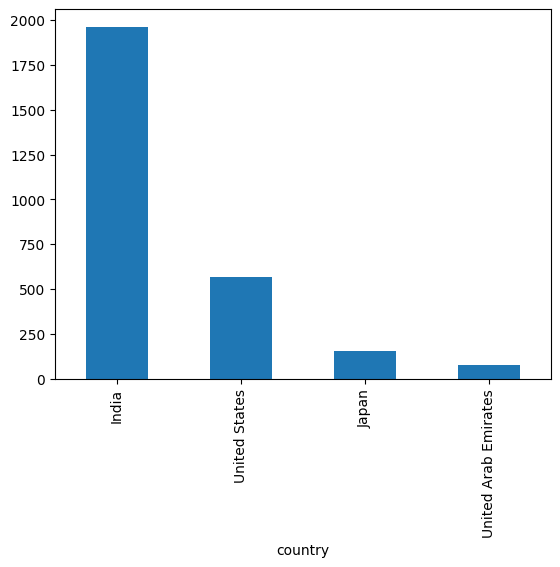

In [ ]:
df['country'].value_counts().plot(kind='bar')
plt.show()

Color wise distribution

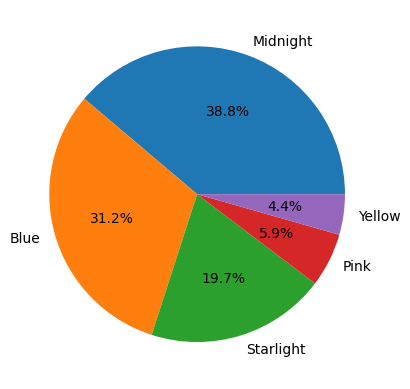

In [ ]:
MidnightSize = df['variant'].str.contains('Color: MidnightSize', na = False).sum()
Blue = df['variant'].str.contains('Color: Blue', na = False).sum()
Starlight = df['variant'].str.contains('Color: Starlight', na = False).sum()
Pink = df['variant'].str.contains('Color: Pink', na = False).sum()
Yellow = df['variant'].str.contains('Color: Yellow', na = False).sum()

plt.pie([MidnightSize, Blue, Starlight, Pink, Yellow], labels=['Midnight', 'Blue', 'Starlight', 'Pink','Yellow'], autopct='%1.1f%%')
plt.show()

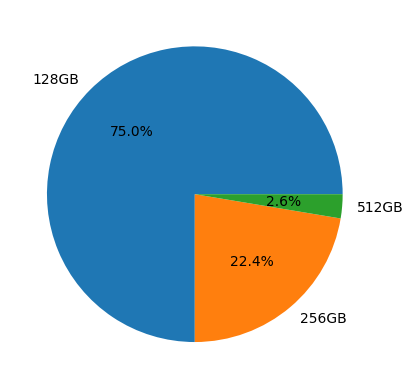

In [ ]:
Size_128 = df['variant'].str.contains('Size: 128GB', na = False).sum()
Size_256 = df['variant'].str.contains('Size: 256GB', na = False).sum()
Size_512 = df['variant'].str.contains('Size: 512GB', na = False).sum()
plt.pie([Size_128, Size_256, Size_512], labels=['128GB', '256GB', '512GB'], autopct='%1.1f%%')
plt.show()


More than half of the ratings have a 5-star rating.



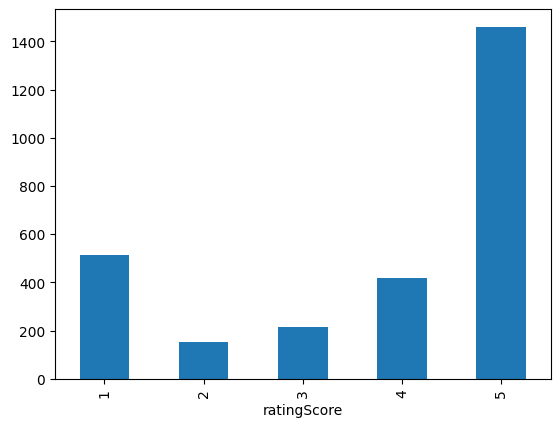

In [ ]:
df['ratingScore'].value_counts().reindex([1, 2, 3, 4, 5]).plot(kind='bar')
plt.show()

plt.show()

In [ ]:
df[df['ratingScore'] == 5]['variant'].describe()


,variant
count,1460
unique,69
top,Colour: BlueSize: 128 GB
freq,113


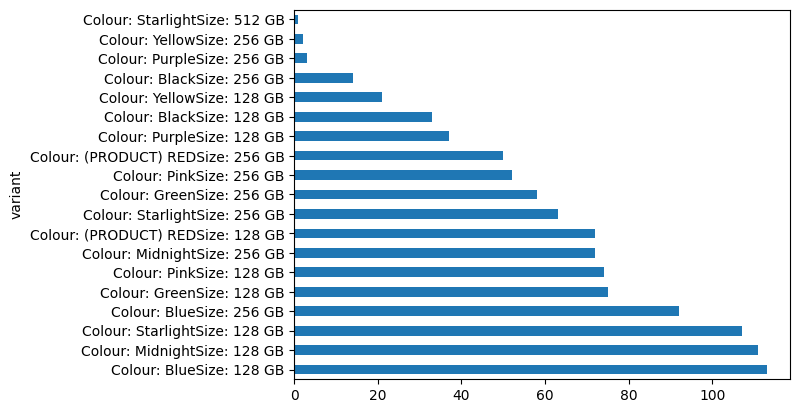

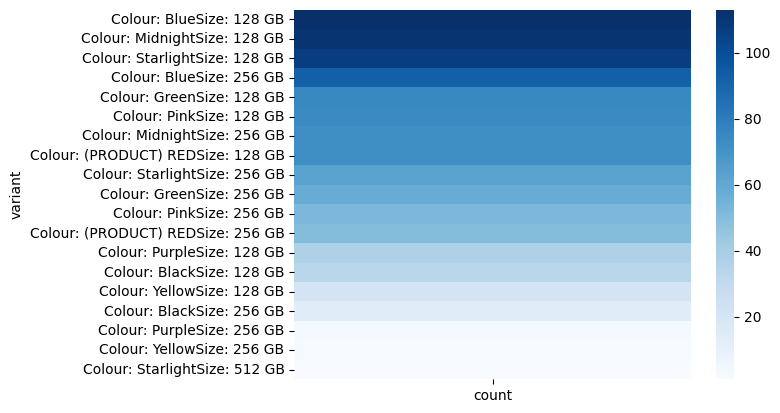

In [ ]:
filtered = df[(df['ratingScore'] == 5) & (df['country']=='India')]
filtered['variant'].value_counts().plot(kind='barh')
plt.show()
# Heat map
sns.heatmap(filtered['variant'].value_counts().to_frame(), cmap='Blues')
plt.show()


Merge the ‘reviewTitle’ and ‘reviewDescription’ into a single ‘review’ for more comprehensive analysis

In [ ]:
df['review'] = df['reviewTitle'] + ' ' + df['reviewDescription']

Generate a Word Cloud for all reviews

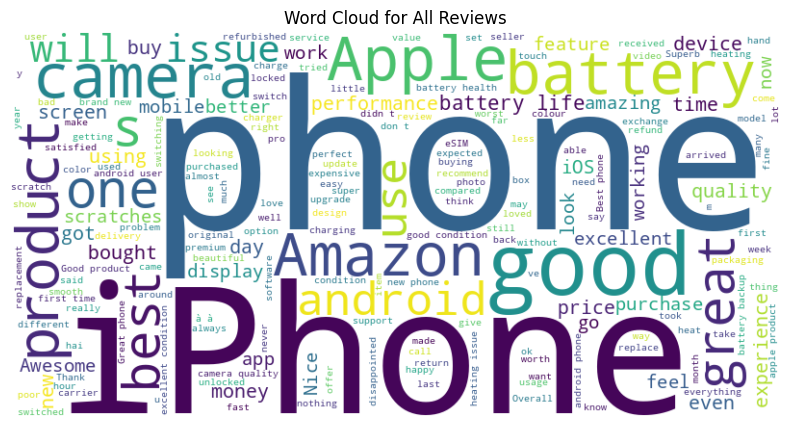

In [ ]:
all_text = ' '.join(review for review in df['review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews')
plt.show()

Instead of analyzing all the reviews, focus on the ones that have more meaningful information based on ‘word_count’. Then, focus on the top 100, 500, and 1000 reviews to gain deep insights into the reviews and perform sentiment analysis.


In [ ]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
sorted_df = df.sort_values(by='word_count', ascending=False)
# Top 100 reviews
top100 = sorted_df.nlargest(100, 'word_count')
top100.to_csv('top100_wordcounts.csv', index=False)
# Top 500 reviews
top500 = sorted_df.nlargest(500, 'word_count')
top500.to_csv('top500_reviews.csv', index=False)
# Top 1000 reviews
top1000 = sorted_df.nlargest(1000, 'word_count')
top1000.to_csv('top1000_reviews.csv', index=False)

Sentiment analysis using VADER

<Axes: xlabel='compound'>

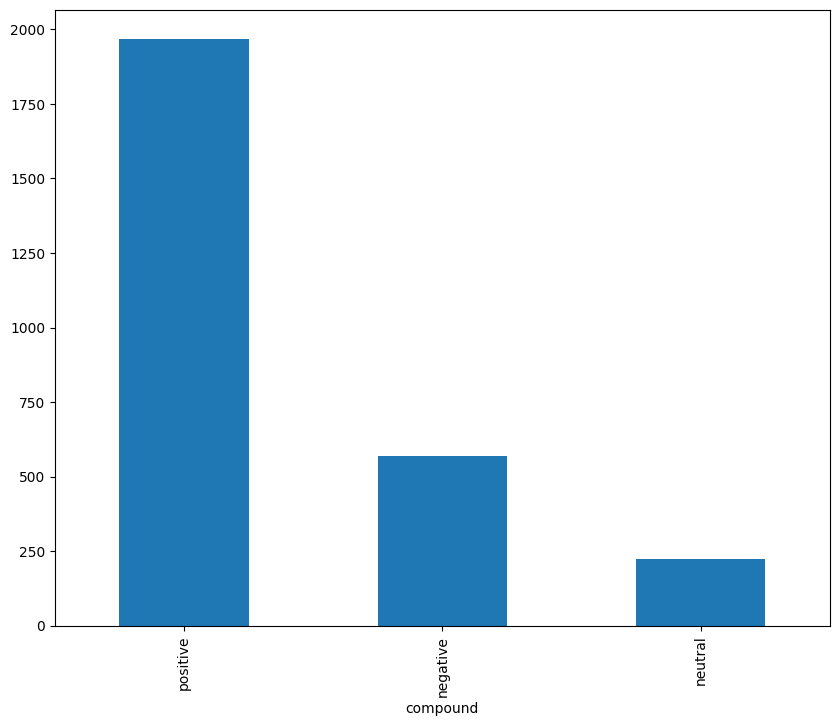

In [ ]:

analyzer = SentimentIntensityAnalyzer()
def analyze_reviews_sentiment(text):
  if pd.isna(text) or not isinstance(text, str) or len(text.strip()) == 0:
      return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
  try:
      sentiment_scores = analyzer.polarity_scores(text)
      return sentiment_scores
  except Exception as e:
      print(f"Error analyzing sentiment: {text[:50]}, error: {e}")
      return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}

df['sentiment_scores'] = df['review'].apply(analyze_reviews_sentiment)
df['neg'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neu'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['pos'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

# Plot based on sentiment analysis: positive, negative, neutral
plt.figure(figsize=(10,8))
sentiment_counts = df['compound'].apply(lambda x: 'positive' if x >= 0.05 else ('negative') if x <= -0.05 else 'neutral').value_counts()
sentiment_counts.plot(kind='bar')
